In [3]:
from pynwb import NWBHDF5IO
#from nwbwidgets import nwb2widget
import h5py, glob, os
import numpy as np
import matplotlib.pyplot as plt
from dlab import sglx_analysis as sglx
from dlab import psth_and_raster as pr
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm as tqdm
import glob
import pickle as pkl
import json
import datetime as dt
import h5py
from dlab import sglx_analysis as sglx
# import jlh_ephys as jlh
import matplotlib.pyplot as plt
# from open_ephys.analysis import Session
import seaborn as sns

class Estim_Ephys:

    def __init__(self,nwb_path):
        self.nwb_path = nwb_path
        self.nwb = None

    def nwb(self):
        if self.nwb is None:
            self.load_nwb()
        return self.nwb

    def load_nwb(self):
        nwb_path = self.nwb_path
        io = NWBHDF5IO(nwb_path, 'r')
        nwb = io.read()
        self.nwb = nwb
        return self.nwb
    

    def trials(self):
        self.load_nwb()
        nwb = self.nwb
        trials_df = nwb.trials.to_dataframe()
        trials_df.loc[2100:2699,'contacts'] = '10r'  #specific to this recording, fixes an error in dataframe
        # Add a new column 'pulse_number' to the DataFrame
        # trials_df = trials_df.assign(pulse_number=trials_df.groupby('run').cumcount() + 1)
        return trials_df
    
    # def add_run_column(self):
    #     self.load_nwb()
    #     trials_df = self.trials()
    #     # Creating a 'run' column with values from 1 to the length of the DataFrame
    #     trials_df['run'] = np.arange(1, len(trials_df) + 1)
    #     return trials_df

    
    def units(self):
        self.load_nwb()
        nwb = self.nwb
        units_df = nwb.units.to_dataframe()
        #adds distance to units dataframe
        units_df['distance_from_stim'] = 0
        dist_a = np.array(units_df.loc[units_df.probe == 'A'].depth - 804)
        dist_b = np.array(units_df.loc[units_df.probe == 'B'].depth - 693)
        dist_c = np.array(units_df.loc[units_df.probe == 'C'].depth - 1238)
        distance_from_stim = np.concatenate((dist_a,dist_b,dist_c))
        units_df['distance_from_stim'] = distance_from_stim
        return units_df

    def parameters(self):
        self.load_nwb()
        trials = self.trials()
        # trials = trials.self
        # dictionary of run information
        parameters = {}
        for run in trials.run.unique():
            amp = np.array(trials.loc[trials.run == run].amplitude)[0]
            pulse_width = np.array(trials.loc[trials.run == run].pulse_duration)[0]
            contacts = np.array(trials.loc[trials.run == run].contacts)[0]
            parameters[run] = f'amp: {amp} um    pw: {pulse_width} us  contacts: {contacts}'
        return parameters

     
    def all_psth(self):
        self.load_nwb()
        self.units()
        self.trials()
        self.parameters()
        plt.figure(figsize=(10, 6))
        # We will iterate over each row (neuron) in the DataFrame
        for index, row in units.iterrows():
            # Each row's 'spike_times' column contains the array of spike times
            spike_times = row['spike_times']
            # We create a y-coordinate array filled with the current index (neuron number),
            # with the same length as the spike_times array
            neuron_numbers = [index] * len(spike_times)
            # Create a scatter plot for this neuron's spike times
            plt.scatter(spike_times, neuron_numbers, s=1)  # s sets the size of the dots
        # After plotting all neurons' spikes, display the plot
        plt.show()

 
    def psth_time_window(self, start_time, stop_time):
        self.load_nwb()
        self.trials()
        self.parameters()
        units_df = self.units() 
        plt.figure(figsize=(10, 6))

        # We will iterate over each row (neuron) in the DataFrame
        for index, row in units_df.iterrows():  # use units_df directly
            
            # Each row's 'spike_times' column contains the array of spike times
            # We filter these spike times based on the start_time and stop_time
            spike_times = [time for time in row['spike_times'] if start_time <= time <= stop_time]

            # We create a y-coordinate array filled with the current index (neuron number),
            # with the same length as the filtered spike_times array
            neuron_numbers = [index] * len(spike_times)

            # Create a scatter plot for this neuron's spike times
            plt.scatter(spike_times, neuron_numbers, s=1)  # s sets the size of the dots
        plt.show()

    def single_neuron_psth(self, neuron_index):
        self.load_nwb()
        units_df = self.units() 
        self.trials()
        self.parameters()
        plt.figure(figsize=(10, 6))

        # We will iterate over each row (neuron) in the DataFrame
        for index, row in units_df.iterrows():
            # If this is not the selected neuron, skip it
            if index != neuron_index:
                continue

            # Each row's 'spike_times' column contains the array of spike times
            spike_times = row['spike_times']
            # We create a y-coordinate array filled with the current index (neuron number),
            # with the same length as the spike_times array
            neuron_numbers = [index] * len(spike_times)
            # Create a scatter plot for this neuron's spike times
            plt.scatter(spike_times, neuron_numbers, s=1)  # s sets the size of the dots

        # After plotting the selected neuron's spikes, display the plot
        plt.show()

    def multi_neuron_psth(self, neuron_indices):
        self.load_nwb()
        units_df = self.units() 
        self.trials()
        self.parameters()
        plt.figure(figsize=(10, 6))

        # We will iterate over each row (neuron) in the DataFrame
        for index, row in units_df.iterrows():
            # If this neuron is not in the list of selected neurons, skip it
            if index not in neuron_indices:
                continue

            # Each row's 'spike_times' column contains the array of spike times
            spike_times = row['spike_times']
            # We create a y-coordinate array filled with the current index (neuron number),
            # with the same length as the spike_times array
            neuron_numbers = [index] * len(spike_times)
            # Create a scatter plot for this neuron's spike times
            plt.scatter(spike_times, neuron_numbers, s=1)  # s sets the size of the dots

        # After plotting the selected neurons' spikes, display the plot
        plt.show()


    def multi_neuron_time_psth(self, neuron_indices, time_window):
        self.load_nwb()
        self.trials()
        self.parameters()
        units_df = self.units()
        plt.figure(figsize=(10, 6))
        start_time, stop_time = time_window

        # Iterate over each row (neuron) in the DataFrame
        for index, row in units_df.iterrows():
            # If this neuron is not in the list of selected neurons, skip it
            if index not in neuron_indices:
                continue

            # Each row's 'spike_times' column contains the array of spike times
            # We filter these spike times based on the start_time and stop_time
            spike_times = [time for time in row['spike_times'] if start_time <= time <= stop_time]
            
            # Create a y-coordinate array filled with the current index (neuron number),
            # with the same length as the filtered spike_times array
            neuron_numbers = [index] * len(spike_times)

            # Create a scatter plot for this neuron's spike times
            plt.scatter(spike_times, neuron_numbers, s=1)  # s sets the size of the dots

        # After plotting all neurons' spikes, display the plot
        plt.show()

    def all_raster(self):
        self.load_nwb()
        units_df = self.units() 
        self.trials()
        self.parameters()
        plt.figure(figsize=(10, 6))
        
        # Empty lists to store neuron indices and their spike counts
        neuron_indices = []
        spike_counts = []
        
        # Iterate over each row (neuron) in the DataFrame
        for index, row in units_df.iterrows():
            # Append the neuron index and its spike count to the respective lists
            neuron_indices.append(index)
            spike_counts.append(len(row['spike_times']))

        # Generate a raster plot with neuron indices on x-axis and spike counts on y-axis
        plt.bar(neuron_indices, spike_counts)
        
        # Set the plot title and labels
        plt.title("Neuron Spike Counts")
        plt.xlabel("Neuron Index")
        plt.ylabel("Spike Count")

        # Display the plot
        plt.show()

    import numpy as np

    def firing_frequency_distribution(self, num_bins=10):
        self.load_nwb()
        units_df = self.units() 
        self.trials()
        self.parameters()
        plt.figure(figsize=(10, 6))

        # Calculate the firing frequency for each neuron (spike count / trial duration)
        firing_frequencies = [len(row['spike_times']) / self.trials()['start_time'].max() for _, row in units_df.iterrows()]

        # Bin the neurons based on their firing frequencies
        bins = np.linspace(min(firing_frequencies), max(firing_frequencies), num_bins)
        neuron_bins = np.digitize(firing_frequencies, bins)

        # Count the number of neurons in each bin
        bin_counts = np.bincount(neuron_bins)

        # Generate a raster plot with neuron bins on x-axis and firing frequency on y-axis
        plt.bar(range(1, len(bin_counts)), bin_counts[1:])  # Ignore the first bin (it will contain all neurons with zero frequency)

        # Set the plot title and labels
        plt.title("Firing Frequency Distribution")
        plt.xlabel("Neuron Bins")
        plt.ylabel("Firing Frequency")

        # Display the plot
        plt.show()

    def get_run_time_windows(self):
        self.load_nwb()
        units_df = self.units() 
        self.trials()

        # Group the DataFrame by the 'run' column and find the first 'start_time' and last 'end_time' for each group
        run_time_windows = trials_df.groupby('run').agg({'start_time': 'min', 'stop_time': 'max'})

        # The resulting DataFrame will have 'run' as the index, and the 'start_time' and 'end_time' for each run as columns
        return run_time_windows

    # def plot_run_window(self,run_number):
    #     self.get_run_time_windows()
    #     self.load_nwb()
    #     units_df = self.units() 
    #     self.trials()
    #     self.parameters()
    #     self.get_run_time_windows()
    #     plt.figure(figsize=(10, 6))
        
    #     # Empty lists to store neuron indices and their spike counts
    #     neuron_indices = []
    #     spike_counts = []
        
    #     # Iterate over each row (neuron) in the DataFrame
    #     for index, row in units_df.iterrows():
    #         # Append the neuron index and its spike count to the respective lists
    #         neuron_indices.append(index)
    #         spike_counts.append(len(row['spike_times']))

        
    #     # Generate a raster plot with neuron indices on x-axis and spike counts on y-axis
    #     plt.bar(neuron_indices, spike_counts)
    #     plt.xlim(run_time_windows[1][run_number],run_time_windows[2][run_number])
        
    #     # Set the plot title and labels
    #     plt.title("Neuron Spike Counts")
    #     plt.xlabel("Neuron Index")
    #     plt.ylabel("Spike Count")

    #     # Display the plot
    #     plt.show()
    
    def plot_run_window(self,run_number):
            self.load_nwb()
            self.trials()
            self.parameters()
            units_df = self.units() 
            run_time_windows = self.get_run_time_windows()
            plt.figure(figsize=(10, 6))

            # We will iterate over each row (neuron) in the DataFrame
            for index, row in units_df.iterrows():  # use units_df directly
                
                # Each row's 'spike_times' column contains the array of spike times
                # We filter these spike times based on the start_time and stop_time
                spike_times = [time for time in row['spike_times'] if run_time_windows.loc[run_number, 'start_time'] <= time <= run_time_windows.loc[run_number, 'stop_time']]

                # We create a y-coordinate array filled with the current index (neuron number),
                # with the same length as the filtered spike_times array
                neuron_numbers = [index] * len(spike_times)

                # Create a scatter plot for this neuron's spike times
                plt.scatter(spike_times, neuron_numbers, s=1)  # s sets the size of the dots
            plt.show()

    def plot_pulse_window(self, run_number, pulse_number):
        self.load_nwb()
        self.trials()
        self.parameters()
        trials_df = self.trials()
        plt.figure(figsize=(10, 6))

        # Filter the trials_df for specific run_number and pulse_number
        trial = trials_df[(trials_df['run'] == run_number) & (trials_df['pulse_number'] == pulse_number)]

        if not trial.empty:
            start_time = trial['start_time'].values[0]
            stop_time = trial['stop_time'].values[0]

            # We will iterate over each row (neuron) in the units DataFrame
            units_df = self.units()
            for index, row in units_df.iterrows():
                # Each row's 'spike_times' column contains the array of spike times
                # We filter these spike times based on the start_time and stop_time
                spike_times = [time for time in row['spike_times'] if start_time <= time <= stop_time]

                # We create a y-coordinate array filled with the current index (neuron number),
                # with the same length as the filtered spike_times array
                neuron_numbers = [index] * len(spike_times)

                # Create a scatter plot for this neuron's spike times
                plt.scatter(spike_times, neuron_numbers, s=1)  # s sets the size of the dots
            plt.show()
        else:
            print("No trial found with the given run_number and pulse_number.")



    def plot_run_window_eopn(self, run_number):
        self.load_nwb()
        self.trials()
        self.parameters()
        units_df = self.units()
        run_time_windows = self.get_run_time_windows()
        plt.figure(figsize=(10, 6))

        # We will iterate over each row (neuron) in the DataFrame
        for index, row in units_df.iterrows():
            # Filter these spike times based on the run time window
            spike_times = [time for time in row['spike_times'] if run_time_windows.loc[run_number, 'start_time'] <= time <= run_time_windows.loc[run_number, 'stop_time']]
            # ID value from the corresponding row in trials DataFrame
            id_value = self.trials().loc[self.trials()['run'] == run_number, 'ID'].iloc[0]
            # Create a y-coordinate array filled with the ID value
            neuron_numbers = [id_value] * len(spike_times)
            # Create a scatter plot for this neuron's spike times
            plt.scatter(spike_times, neuron_numbers, s=1)  # s sets the size of the dots

        plt.show()



        



      



In [4]:
nwb_path = "/Users/grant/Documents/coding/neural_data/jlh31.nwb" 

jlh31 = Estim_Ephys(nwb_path)


In [5]:
jlh31.plot_pulse_window(2,3)

UnsupportedOperation: Unable to open file /Users/grant/Documents/coding/neural_data/jlh31.nwb in 'r' mode. File does not exist.

In [89]:
jlh31.trials()

,start_time,stop_time,train_duration,train_period,train_quantity,shape,run,pulse_duration,pulse_number,event_period,amplitude,contacts,notes
id,,,,,,,,,,,,,
0,1991.613600,1993.613600,1.0,2.0,75,biphasic,0,100,1,10.0,-25,16r_2b,
1,1993.615600,1995.615600,1.0,2.0,75,biphasic,0,100,1,10.0,-25,16r_2b,
2,1995.617600,1997.617600,1.0,2.0,75,biphasic,0,100,1,10.0,-25,16r_2b,
3,1997.619600,1999.619600,1.0,2.0,75,biphasic,0,100,1,10.0,-25,16r_2b,
4,1999.621600,2001.621600,1.0,2.0,75,biphasic,0,100,1,10.0,-25,16r_2b,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,8431.015833,8433.015833,1.0,2.0,50,biphasic,36,200,1,10.0,25,10r,
2696,8433.017833,8435.017833,1.0,2.0,50,biphasic,36,200,1,10.0,25,10r,
2697,8435.019833,8437.019833,1.0,2.0,50,biphasic,36,200,1,10.0,25,10r,


In [90]:
jlh31.parameters()

{0: 'amp: -25 um    pw: 100 us  contacts: 16r_2b',
 1: 'amp: 25 um    pw: 100 us  contacts: 16r_2b',
 2: 'amp: -50 um    pw: 100 us  contacts: 16r_2b',
 3: 'amp: 50 um    pw: 100 us  contacts: 16r_2b',
 4: 'amp: -100 um    pw: 100 us  contacts: 16r_2b',
 5: 'amp: -5 um    pw: 100 us  contacts: 16r_2b',
 6: 'amp: 5 um    pw: 100 us  contacts: 16r_2b',
 7: 'amp: -10 um    pw: 100 us  contacts: 16r_2b',
 8: 'amp: 10 um    pw: 100 us  contacts: 16r_2b',
 9: 'amp: 100 um    pw: 100 us  contacts: 16r_2b',
 10: 'amp: -5 um    pw: 100 us  contacts: 10r_7b',
 11: 'amp: 5 um    pw: 100 us  contacts: 10r_7b',
 12: 'amp: -25 um    pw: 100 us  contacts: 10r_7b',
 13: 'amp: 25 um    pw: 100 us  contacts: 10r_7b',
 14: 'amp: -50 um    pw: 100 us  contacts: 10r_7b',
 15: 'amp: 50 um    pw: 100 us  contacts: 10r_7b',
 16: 'amp: -5 um    pw: 100 us  contacts: 16r',
 17: 'amp: 5 um    pw: 100 us  contacts: 16r',
 18: 'amp: -25 um    pw: 100 us  contacts: 16r',
 19: 'amp: 25 um    pw: 100 us  contacts: 16

In [64]:
jlh31.units()

,probe,unit_id,group,depth,xpos,zpos,no_spikes,KSlabel,KSamplitude,KScontamination,template,ch,depth_clusterinfo,spike_times,electrodes,distance_from_stim
id,,,,,,,,,,,,,,,,
17,A,18,good,1867.199263,21.388632,3707.199263,1330,good,1126.2,8.4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",12,140.0,"[1912.8599099778542, 1917.326090516744, 1926.7...",x y z imp location fil...,1063.199263
18,A,19,good,1858.631542,18.395251,3698.631542,3919,mua,1136.3,14.1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",12,140.0,"[1868.5826581533997, 1869.1266458802747, 1869....",x y z imp location fil...,1054.631542
25,A,29,good,1844.259375,39.586650,3684.259375,13436,mua,1522.9,20.3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",15,160.0,"[1862.9601605142796, 1864.0606464457574, 1864....",x y z imp location fil...,1040.259375
28,A,32,good,1816.547338,33.566069,3656.547338,6148,good,2065.5,3.3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",16,180.0,"[1861.2514770107605, 1862.0472618615795, 1864....",x y z imp location fil...,1012.547338
29,A,33,good,1828.298987,40.237474,3668.298987,7599,mua,1161.3,27.6,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",17,180.0,"[1861.1088346934694, 1861.2739994819099, 1870....",x y z imp location fil...,1024.298987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,C,650,good,139.450572,47.332545,1979.450572,14541,good,2486.9,4.8,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",185,1860.0,"[1860.4991559953241, 1860.5021923527436, 1860....",x y z imp location fil...,-1098.549428
580,C,652,good,1445.429014,48.876085,3285.429014,19139,good,830.2,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",53,540.0,"[1861.395369776179, 1861.8246306656322, 1861.8...",x y z imp location fil...,207.429014
581,C,654,good,1305.607888,16.735198,3145.607888,4334,good,1435.9,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",68,700.0,"[1907.2308807601537, 1908.496717400991, 1916.0...",x y z imp location fi...,67.607888


In [44]:
eopn3.units()

,depth,xpos,ypos,label,KSlabel,KSamplitude,KScontamination,probe,spike_times,electrodes,waveform_mean,distance_from_stim
id,,,,,,,,,,,,
0,1013.195409,30.683947,3795.195409,0,1,1016.1,100.2,A,"[1109.4048936263537, 1109.818320648671, 1110.2...",location ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",209.195409
1,938.338041,31.053864,3720.338041,0,1,883.9,80.4,A,"[1108.9367264189364, 1108.938428117146, 1110.3...",location ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",134.338041
2,983.547308,27.801565,3765.547308,0,1,513.9,43.3,A,"[1107.0035413375556, 1107.0217915700377, 1107....",location ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",179.547308
3,925.189943,29.911659,3707.189943,0,1,922.2,244.3,A,"[1104.5537168053509, 1106.3120356802092, 1107....",location ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",121.189943
4,973.527915,33.743584,3755.527915,2,2,1129.2,7.4,A,"[1107.0476822106343, 1108.0015932361373, 1108....",location ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",169.527915
...,...,...,...,...,...,...,...,...,...,...,...,...
1384,-2333.371572,26.729427,471.628428,0,1,684.9,0.0,C,"[1134.154436008208, 1508.7308162236252, 1522.1...",location ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-3571.371572
1385,-1154.576101,45.339119,1650.423899,1,2,831.3,100.0,C,"[1116.516382634238, 1119.405341263333, 1121.69...",location ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-2392.576101
1386,-1984.479906,15.740321,820.520094,0,1,1249.9,0.0,C,"[1142.7195634904638, 1166.3699626412435, 1170....",location ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",-3222.479906


NameError: name 'trials' is not defined

In [42]:
eopn3.add_run_column()

,start_time,stop_time,stimulus,optogenetics_LED_state,flash_luminance,contacts,run
id,,,,,,,
0,1630.086600,1633.091398,luminance_flash,0,0,NaN,1
1,1633.082600,1636.087398,luminance_flash,0,1,NaN,2
2,1636.086300,1639.091098,luminance_flash,1,0,NaN,3
3,1639.088633,1642.093431,luminance_flash,0,1,NaN,4
4,1642.091526,1645.096324,luminance_flash,0,0,NaN,5
...,...,...,...,...,...,...,...
95,1915.549567,1918.554365,luminance_flash,0,1,NaN,96
96,1918.552900,1921.557698,luminance_flash,1,0,NaN,97
97,1921.555633,1924.560431,luminance_flash,1,1,NaN,98


In [43]:
eopn3.plot_run_window(2)

NameError: name 'trials' is not defined

In [4]:
# G.plot_pulse_window(5, 3)

In [5]:
# G.plot_run_window(1)

In [6]:
# jhl31_units = jhl31.units()
# trials_df = jhl31.trials()


In [7]:
# print(trials_df.groupby('run').size())


In [55]:
G.get_run_time_windows()

NameError: name 'trials_df' is not defined

In [347]:
trials_df.head(75)


,start_time,stop_time,train_duration,train_period,train_quantity,shape,run,pulse_duration,pulse_number,event_period,amplitude,contacts,notes
id,,,,,,,,,,,,,
0,1991.613600,1993.613600,1.0,2.0,75,biphasic,0,100,1,10.0,-25,16r_2b,
1,1993.615600,1995.615600,1.0,2.0,75,biphasic,0,100,1,10.0,-25,16r_2b,
2,1995.617600,1997.617600,1.0,2.0,75,biphasic,0,100,1,10.0,-25,16r_2b,
3,1997.619600,1999.619600,1.0,2.0,75,biphasic,0,100,1,10.0,-25,16r_2b,
4,1999.621600,2001.621600,1.0,2.0,75,biphasic,0,100,1,10.0,-25,16r_2b,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,2131.753267,2133.753267,1.0,2.0,75,biphasic,0,100,1,10.0,-25,16r_2b,
71,2133.755267,2135.755267,1.0,2.0,75,biphasic,0,100,1,10.0,-25,16r_2b,
72,2135.757267,2137.757267,1.0,2.0,75,biphasic,0,100,1,10.0,-25,16r_2b,


In [348]:
jhl31_units.head(5)


,probe,unit_id,group,depth,xpos,zpos,no_spikes,KSlabel,KSamplitude,KScontamination,template,ch,depth_clusterinfo,spike_times,electrodes,distance_from_stim
id,,,,,,,,,,,,,,,,
17,A,18,good,1867.199263,21.388632,3707.199263,1330,good,1126.2,8.4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",12,140.0,"[1912.8599099778542, 1917.326090516744, 1926.7...",x y z imp location fil...,1063.199263
18,A,19,good,1858.631542,18.395251,3698.631542,3919,mua,1136.3,14.1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",12,140.0,"[1868.5826581533997, 1869.1266458802747, 1869....",x y z imp location fil...,1054.631542
25,A,29,good,1844.259375,39.586650,3684.259375,13436,mua,1522.9,20.3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",15,160.0,"[1862.9601605142796, 1864.0606464457574, 1864....",x y z imp location fil...,1040.259375
28,A,32,good,1816.547338,33.566069,3656.547338,6148,good,2065.5,3.3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",16,180.0,"[1861.2514770107605, 1862.0472618615795, 1864....",x y z imp location fil...,1012.547338
29,A,33,good,1828.298987,40.237474,3668.298987,7599,mua,1161.3,27.6,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",17,180.0,"[1861.1088346934694, 1861.2739994819099, 1870....",x y z imp location fil...,1024.298987


In [57]:
G.multi_neuron_time_psth([100,200,300],[1000,2000])

NameError: name 'trials' is not defined

In [54]:
jhl31.firing_frequency_distribution(100)

NameError: name 'jhl31' is not defined

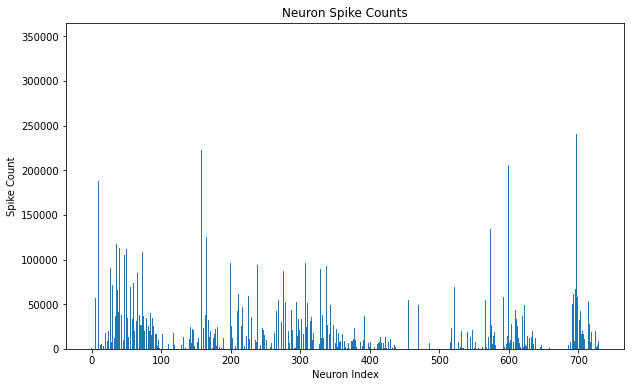

In [334]:
jhl31.all_raster()

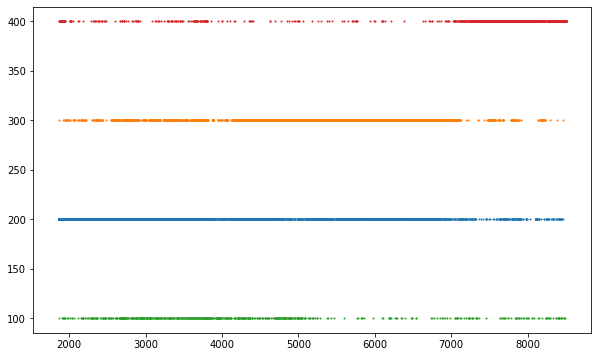

In [301]:
jhl31.multi_neuron_psth([100,200,300,400])

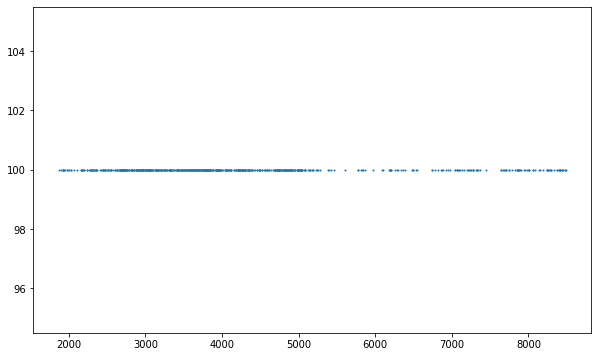

In [295]:
jhl31.single_neuron_psth(100)

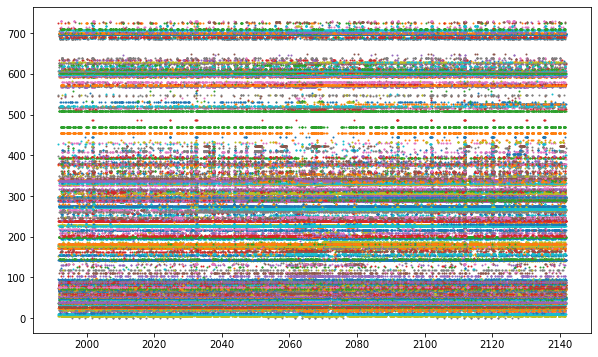

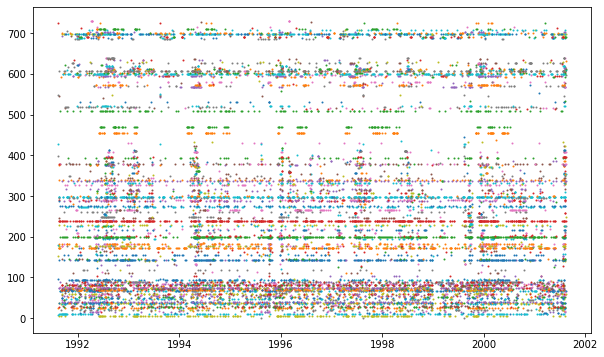

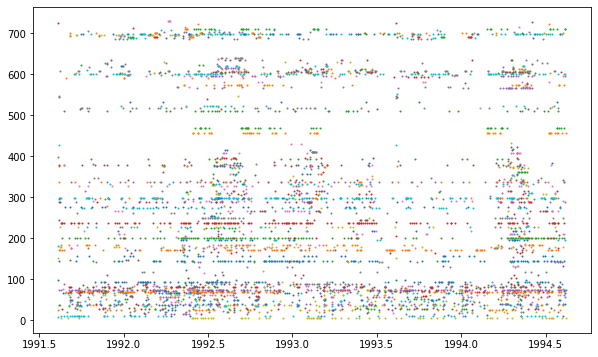

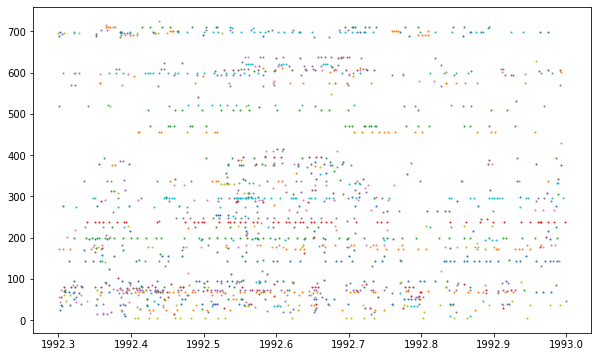

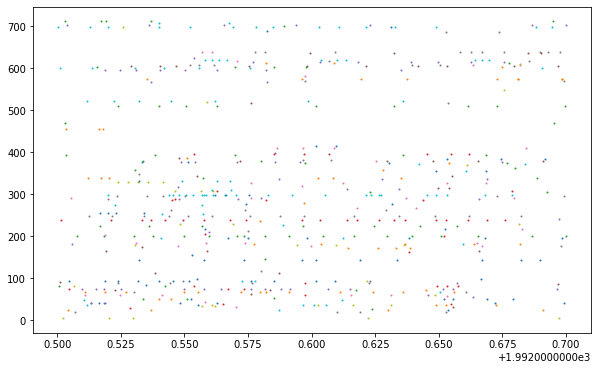

In [331]:
jhl31.psth_time_window(1991.613600,2141.761406) 
jhl31.psth_time_window(1991.613600,2001.621600) 
jhl31.psth_time_window(1991.613600,1994.621600)
jhl31.psth_time_window(1992.3,1993)
jhl31.psth_time_window(1992.5,1992.7)

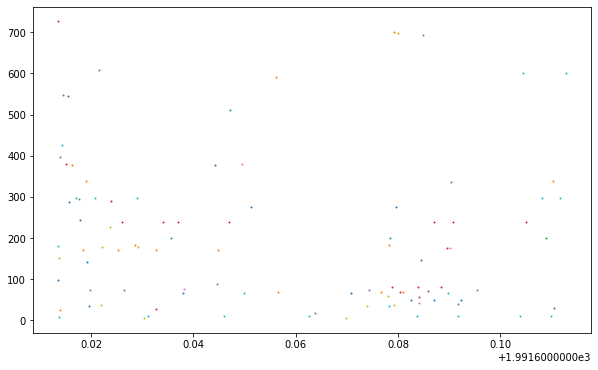

In [352]:
jhl31.psth_time_window(1991.613600,1991.713)

In [255]:
trials_df = jhl31.trials()


In [256]:
trials_df.head()

,start_time,stop_time,train_duration,train_period,train_quantity,shape,run,pulse_duration,pulse_number,event_period,amplitude,contacts,notes
id,,,,,,,,,,,,,
0,1991.6136,1993.6136,1.0,2.0,75,biphasic,0,100,1,10.0,-25,16r_2b,
1,1993.6156,1995.6156,1.0,2.0,75,biphasic,0,100,1,10.0,-25,16r_2b,
2,1995.6176,1997.6176,1.0,2.0,75,biphasic,0,100,1,10.0,-25,16r_2b,
3,1997.6196,1999.6196,1.0,2.0,75,biphasic,0,100,1,10.0,-25,16r_2b,
4,1999.6216,2001.6216,1.0,2.0,75,biphasic,0,100,1,10.0,-25,16r_2b,


In [253]:
units_df = jhl31.units()


In [254]:
units_df.head(5)

,probe,unit_id,group,depth,xpos,zpos,no_spikes,KSlabel,KSamplitude,KScontamination,template,ch,depth_clusterinfo,spike_times,electrodes,distance_from_stim
id,,,,,,,,,,,,,,,,
17,A,18,good,1867.199263,21.388632,3707.199263,1330,good,1126.2,8.4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",12,140.0,"[1912.8599099778542, 1917.326090516744, 1926.7...",x y z imp location fil...,1063.199263
18,A,19,good,1858.631542,18.395251,3698.631542,3919,mua,1136.3,14.1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",12,140.0,"[1868.5826581533997, 1869.1266458802747, 1869....",x y z imp location fil...,1054.631542
25,A,29,good,1844.259375,39.586650,3684.259375,13436,mua,1522.9,20.3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",15,160.0,"[1862.9601605142796, 1864.0606464457574, 1864....",x y z imp location fil...,1040.259375
28,A,32,good,1816.547338,33.566069,3656.547338,6148,good,2065.5,3.3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",16,180.0,"[1861.2514770107605, 1862.0472618615795, 1864....",x y z imp location fil...,1012.547338
29,A,33,good,1828.298987,40.237474,3668.298987,7599,mua,1161.3,27.6,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",17,180.0,"[1861.1088346934694, 1861.2739994819099, 1870....",x y z imp location fil...,1024.298987


In [183]:
jhl31.trials()

       start_time    stop_time  train_duration  train_period  train_quantity  \
id                                                                             
0     1991.613600  1993.613600             1.0           2.0              75   
1     1993.615600  1995.615600             1.0           2.0              75   
2     1995.617600  1997.617600             1.0           2.0              75   
3     1997.619600  1999.619600             1.0           2.0              75   
4     1999.621600  2001.621600             1.0           2.0              75   
...           ...          ...             ...           ...             ...   
2695  8431.015833  8433.015833             1.0           2.0              50   
2696  8433.017833  8435.017833             1.0           2.0              50   
2697  8435.019833  8437.019833             1.0           2.0              50   
2698  8437.021284  8439.021284             1.0           2.0              50   
2699  8439.023833  8441.023833          

<bound method Ephys.trials of <__main__.Ephys object at 0x7f99d3c755e0>>

In [184]:
jhl31.parameters()

       start_time    stop_time  train_duration  train_period  train_quantity  \
id                                                                             
0     1991.613600  1993.613600             1.0           2.0              75   
1     1993.615600  1995.615600             1.0           2.0              75   
2     1995.617600  1997.617600             1.0           2.0              75   
3     1997.619600  1999.619600             1.0           2.0              75   
4     1999.621600  2001.621600             1.0           2.0              75   
...           ...          ...             ...           ...             ...   
2695  8431.015833  8433.015833             1.0           2.0              50   
2696  8433.017833  8435.017833             1.0           2.0              50   
2697  8435.019833  8437.019833             1.0           2.0              50   
2698  8437.021284  8439.021284             1.0           2.0              50   
2699  8439.023833  8441.023833          

<bound method Ephys.parameters of <__main__.Ephys object at 0x7f99d3c755e0>>

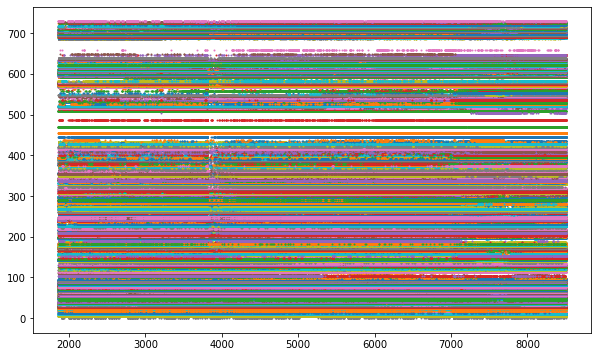

In [257]:
jhl31.all_psth()